### Notebook Overview

This notebook performs a G–2D correlation analysis of Raman spectra collected from a Graphene–MoO₃ heterostructure. The dataset is divided into three distinct regions:

1. **Graphene–MoO₃ overlap**  
2. **Bare graphene**  
3. **Thick MoO₃**

In **Cell 3** of `data_plot_raman_2D.ipynb`, an interactive Matplotlib widget was used to manually select measurement points for each region. Those selections were then saved as separate text files (located alongside this notebook) and serve as the input for all subsequent peak fitting and plotting steps. 

I also defined a custom library named function_lib.py which contains necessary functions for this code to work. Make sure that the library is in the same folder as the notebook or make sure that you provide the correct path to the library while importing.
 


In [1]:
"""Raman map analysis 

Loads a baseline‑subtracted Raman data text export and reshapes it into
21 × 21 × N_w arrays for downstream processing with `function_lib` (imported as
`fn`).  **Variable names are preserved** exactly as they appear in the raw file
for easy cross‑reference.
"""

# %% Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Qt5Agg")

import function_lib as fn  # custom utilities

# %% File path (edit as needed)
folder_path = r"C:\Users\ashfa\OneDrive - The Pennsylvania State University\Shao Group files"
file_name = (
    r"\G-MoS2_532 nm_2024_11_14_12_25_34_600 gr_mm_x100_1_1 s_100_2_5%_01 Baseline subtracted.txt"
)
file_path = folder_path + file_name

# %% Load WiRE ASCII export (55‑line header → skip)
# Falls back to latin‑1 if UTF‑8 fails, without altering variable names.
encodings = ["utf-8", "latin-1"]
for enc in encodings:
    try:
        data_array = []  # will become a list of rows (floats)
        with open(file_path, "r", encoding=enc) as file:
            for _ in range(55):
                next(file)          # skip header rows
            for line in file:
                data_array.append(list(map(float, line.split())))
        break  # successfully decoded → exit loop
    except UnicodeDecodeError:
        continue
else:
    raise UnicodeDecodeError("Unable to decode file; try a different encoding.")

# %% Build coordinate & spectral grids
wave_numbers     = np.array(data_array[0])           # (N_w,)
N_w              = len(wave_numbers)

coordinates      = np.array([row[:2]  for row in data_array[1:]])  # (441, 2)
raman_amplitudes = np.array([row[2:]  for row in data_array[1:]])  # (441, N_w)

data_grid        = raman_amplitudes.reshape(21, 21, N_w)          # (21, 21, N_w)


c:\Users\ashfa\OneDrive - The Pennsylvania State University\Shao Group files\function_lib.py:15: SyntaxWarning: invalid escape sequence '\m'
  """
c:\Users\ashfa\OneDrive - The Pennsylvania State University\Shao Group files\function_lib.py:150: SyntaxWarning: invalid escape sequence '\m'
  """


In [2]:
# Use the Qt backend so the panning/slider widgets appear in their own window
%matplotlib qt

# Open the interactive Raman-map viewer:
#   • Move the slider to scroll through wavenumbers
#   • Hover to see intensity at the cursor
#   • Double-click a pixel to plot its full spectrum
#   • Click “Clear” to reset selections
fn.plot_2d_raman(coordinates, raman_amplitudes, wave_numbers)


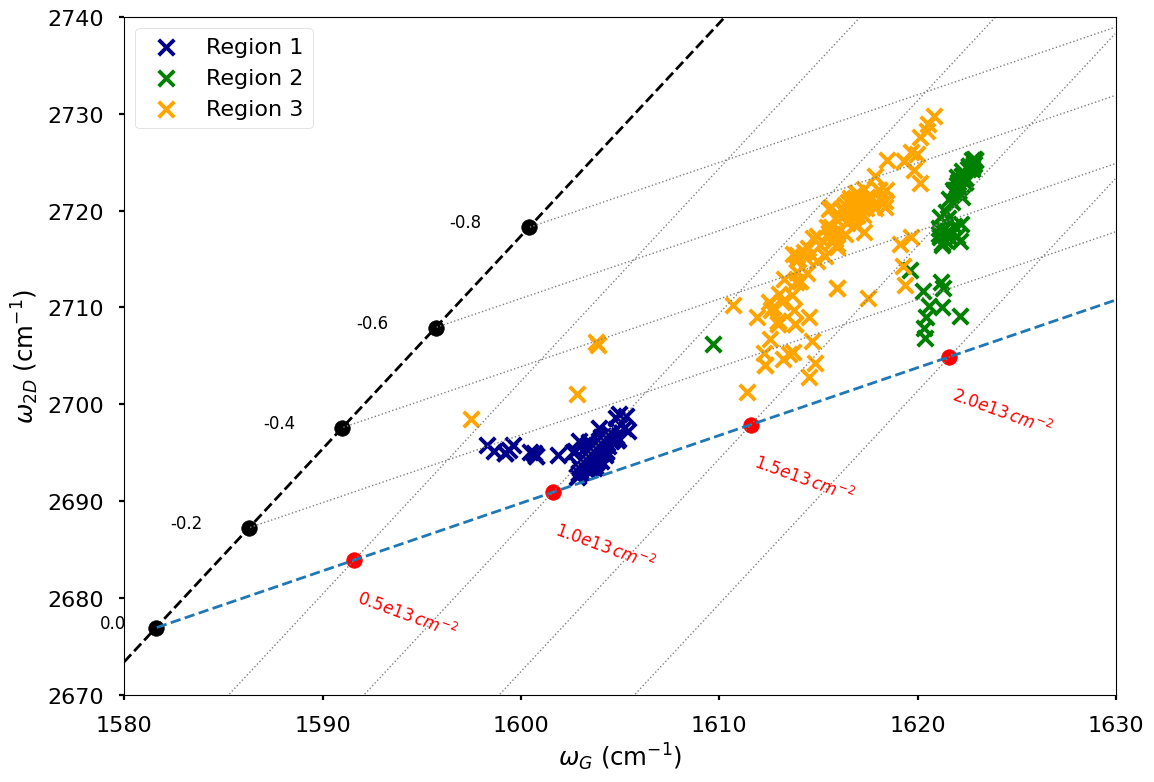

In [5]:
# -------------------------------------------------------------------------
# ITERATION 1 — “larger-peak-left” extraction
# -------------------------------------------------------------------------
#   • For each file we fit the G-band (≈1550–1700 cm⁻¹) and take the centre
#     of whichever Lorentzian sub-peak has the *larger* amplitude.
#   • We do the same for the 2D-band (≈2600–2790 cm⁻¹).
#   • Results from three sample regions are concatenated and colour-coded
#     (0, 1, 2) for plotting.
# -------------------------------------------------------------------------

# ---------- G-band: file 1 (single Lorentzian) ----------
g_g_params = fn.get_peak_params(
    fn.lorentzian,                        # fit function
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700],                         # neighbourhood
    [300, 1600, 10, 10],                 # A, x₀, γ, B
    "g-points.txt"
)
wg_peaks   = g_g_params[:, 1]             # ωG centres
color_code = np.zeros_like(wg_peaks)      # region tag 0

# ---------- G-band: file 2 (double Lorentzian) ----------
initial_guesses2 = [300, 1600, 5,    # A₁, x₀₁, γ₁
                    50,  1620, 5,    # A₂, x₀₂, γ₂
                    10]              # B
moo3_g_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-g.txt"
)
# choose the larger peak (left if A₁ > A₂)
wg_peaks = np.concatenate((wg_peaks,
                           np.where(moo3_g_g_params[:, 0] > moo3_g_g_params[:, 3],
                                    moo3_g_g_params[:, 1],  # left centre
                                    moo3_g_g_params[:, 4])))# right centre
color_code = np.concatenate((color_code,
                             np.ones(wg_peaks.size - color_code.size)))

# ---------- G-band: file 3 (double Lorentzian) ----------
moo3_thick_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-thick.txt"
)
wg_peaks = np.concatenate((wg_peaks,
                           np.where(moo3_thick_g_params[:, 0] > moo3_thick_g_params[:, 3],
                                    moo3_thick_g_params[:, 1],
                                    moo3_thick_g_params[:, 4])))
color_code = np.concatenate((color_code,
                             2 * np.ones(wg_peaks.size - color_code.size)))

# ---------- 2D-band (single Lorentzian for all files) ----------
initial_guesses_2d = [100, 2700, 10, 10]
neighbourhood_2d   = [2600, 2790]

g_2d_params          = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "g-points.txt")
w2d_peaks            = g_2d_params[:, 1]

moo3_g_2d_params     = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-g.txt")
w2d_peaks            = np.concatenate((w2d_peaks, moo3_g_2d_params[:, 1]))

moo3_thick_2d_params = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-thick.txt")
w2d_peaks            = np.concatenate((w2d_peaks, moo3_thick_2d_params[:, 1]))

# ---------- Assemble point list & clean-up ----------
point_list  = []
point_list += list(np.loadtxt("g-points.txt",        delimiter=","))
point_list += list(np.loadtxt("moo3-g.txt",          delimiter=","))
point_list += list(np.loadtxt("moo3-thick.txt",      delimiter=","))

# remove entries with NaNs
mask        = ~np.logical_or(np.isnan(wg_peaks), np.isnan(w2d_peaks))
wg_peaks    = wg_peaks[mask]
w2d_peaks   = w2d_peaks[mask]
point_list  = np.asarray(point_list)[mask]
color_code  = color_code[mask]

# discard ωG < 1500 cm⁻¹ outliers
mask        = wg_peaks >= 1500
wg_peaks    = wg_peaks[mask]
w2d_peaks   = w2d_peaks[mask]
point_list  = point_list[mask]
color_code  = color_code[mask]

# ------------------------------------------------------------------------
# Plot ω2D vs ωG with reference lines for strain, doping, etc.
# ------------------------------------------------------------------------
%matplotlib inline
plt.style.use("seaborn-v0_8-poster")

omega_g_0 = 1581.6   # intrinsic G
omega_2d_0 = 2676.9  # intrinsic 2D
strain_slope = 2.2
hole_slope   = 0.7
G_strain     = -23.5   # dωG/dε (cm-¹ per %)

wG = np.arange(1580, 1630, 0.05)
w2D = np.arange(2630, 2730, 0.05)
line = lambda w, wG0, w2D0, s: s * w + (w2D0 - s * wG0)

fig, ax = plt.subplots()

# strain and hole-doping baselines
ax.plot(wG, line(wG, omega_g_0, omega_2d_0, strain_slope), "--k", lw=2)
ax.plot(wG[wG > omega_g_0],
        line(wG[wG > omega_g_0], omega_g_0, omega_2d_0, hole_slope),
        "--", color="C0", lw=2)

# strain grid (dashed grey lines)
for st in [-0.6, -0.8, -0.4, -0.2, 0]:
    st_G  = omega_g_0 + G_strain * st
    st_2D = strain_slope * st_G + (omega_2d_0 - strain_slope * omega_g_0)
    ax.scatter(st_G, st_2D, c="k")
    ax.text(st_G - (4 if st < 0 else 2.8), st_2D, f"{st:.1f}", fontsize=12)
    if st:
        wGnew = wG[wG > st_G]
        ax.plot(wGnew,
                hole_slope * wGnew + (st_2D - hole_slope * st_G),
                ":", color="grey", lw=1)

# doping grid (red points & dotted grey trajectories)
for n in [0.5e13, 1e13, 1.5e13, 2e13]:
    dG  = 2 * n / 1e12             # empirical shift of ωG
    d2D = dG * hole_slope
    ax.scatter(omega_g_0 + dG, omega_2d_0 + d2D, c="red")
    ax.plot(wG,
            omega_2d_0 + d2D + strain_slope * (wG - omega_g_0 - dG),
            ":", color="grey", lw=1)
    ax.text(omega_g_0 + dG,
            omega_2d_0 + d2D - 8,
            f"{n*1e-13:.1f}$e13\\,cm^{{-2}}$",
            color="red", rotation=-20, fontsize=12)

# data points (three regions, colour-coded)
colors       = ["darkblue", "green", "orange"]
label_array  = ["Region 1", "Region 2", "Region 3"]
for code, c, label in zip(range(3), colors, label_array):
    ax.scatter(wg_peaks[color_code == code],
               w2d_peaks[color_code == code],
               c=c, marker="x", label=label)

ax.set_xlim(1580, 1630)
ax.set_ylim(2670, 2740)
ax.set_xlabel("$\\omega_G$ (cm$^{-1}$)")
ax.set_ylabel("$\\omega_{2D}$ (cm$^{-1}$)")
ax.legend()
plt.show()


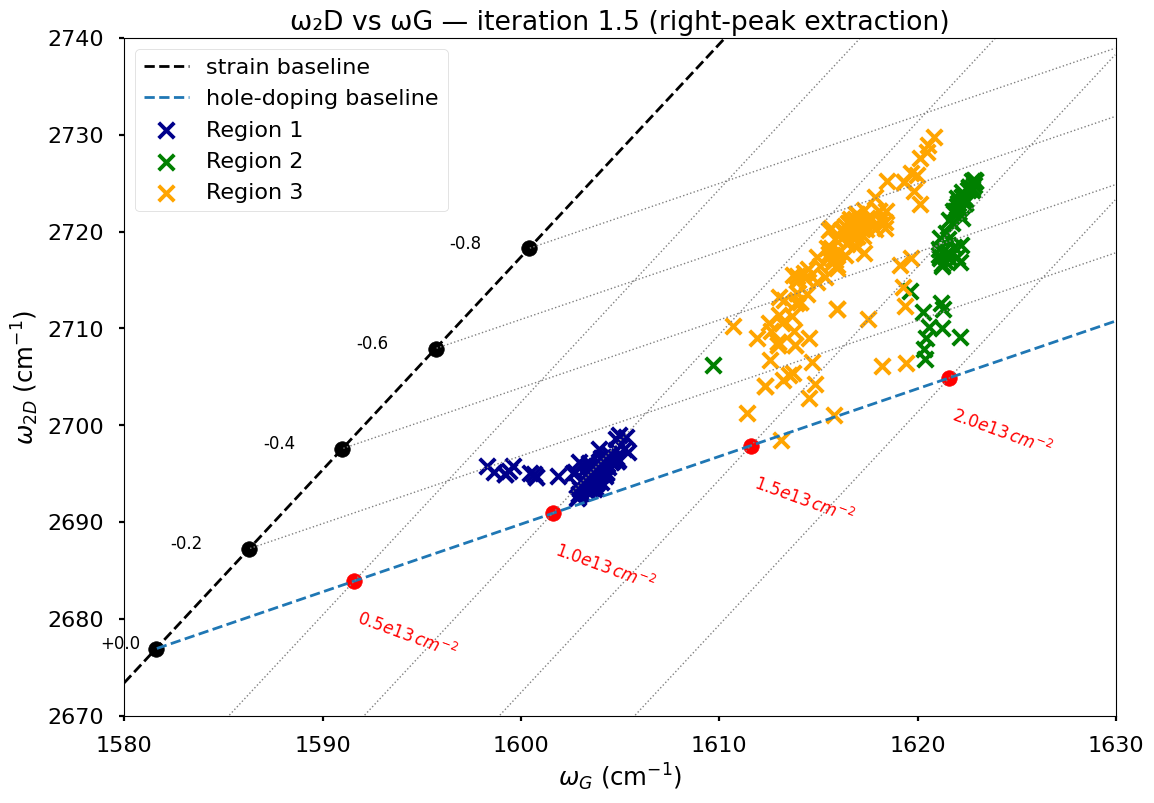

In [9]:
# ---------------------------------------------------------------------
# ωG-ω2D correlation plot – iteration 1.5
# Strategy: for double-Lorentzian G-band fits keep the **right-hand peak**
# ---------------------------------------------------------------------

# ──────────────────────────────
# 1.  Extract ωG (G-band centres)
# ──────────────────────────────
# File 1 – single Lorentzian fit
g_g_params = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700],                # fitting window (cm⁻¹)
    [300, 1600, 10, 10],         # A, x₀, γ, B initial guess
    "g-points.txt"               # list of (x, y) positions
)
wg_peaks   = g_g_params[:, 1]    # centre positions
color_code = np.zeros_like(wg_peaks)   # region tag → 0

# File 2 – double Lorentzian: keep the **higher-frequency** component
initial_guesses2 = [300, 1600, 5,   # A₁, x₀₁, γ₁
                    50,  1620, 5,   # A₂, x₀₂, γ₂
                    10]             # B
moo3_g_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-g.txt"
)
wg_peaks = np.concatenate((
    wg_peaks,
    np.array([max(arr[1], arr[4]) for arr in moo3_g_g_params])  # right peak
))
color_code = np.concatenate((color_code,
                             np.ones(wg_peaks.size - color_code.size)))

# File 3 – double Lorentzian (same rule)
moo3_thick_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-thick.txt"
)
wg_peaks = np.concatenate((
    wg_peaks,
    np.array([max(arr[1], arr[4]) for arr in moo3_thick_g_params])
))
color_code = np.concatenate((color_code,
                             2 * np.ones(wg_peaks.size - color_code.size)))

# ──────────────────────────────
# 2.  Extract ω2D (2D-band centres, single Lorentzian)
# ──────────────────────────────
initial_guesses_2d = [100, 2700, 10, 10]
neighbourhood_2d   = [2600, 2790]

g_2d_params          = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "g-points.txt")
w2d_peaks            = g_2d_params[:, 1]

moo3_g_2d_params     = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-g.txt")
w2d_peaks            = np.concatenate((w2d_peaks, moo3_g_2d_params[:, 1]))

moo3_thick_2d_params = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-thick.txt")
w2d_peaks            = np.concatenate((w2d_peaks, moo3_thick_2d_params[:, 1]))

# ──────────────────────────────
# 3.  Collect point coordinates (for reference)
# ──────────────────────────────
point_list = []
point_list += list(np.loadtxt("g-points.txt",        delimiter=","))
point_list += list(np.loadtxt("moo3-g.txt",          delimiter=","))
point_list += list(np.loadtxt("moo3-thick.txt",      delimiter=","))

# ──────────────────────────────
# 4.  Clean-up: remove NaNs and simple outliers
# ──────────────────────────────
mask        = ~np.logical_or(np.isnan(wg_peaks), np.isnan(w2d_peaks))
wg_peaks    = wg_peaks[mask]
w2d_peaks   = w2d_peaks[mask]
point_list  = np.asarray(point_list)[mask]
color_code  = color_code[mask]

mask        = wg_peaks >= 1500      # discard obvious mis-fits
wg_peaks    = wg_peaks[mask]
w2d_peaks   = w2d_peaks[mask]
point_list  = point_list[mask]
color_code  = color_code[mask]

# ──────────────────────────────
# 5.  Plot ω2D vs ωG with strain / doping grids
# ──────────────────────────────
%matplotlib inline
plt.style.use("seaborn-v0_8-poster")

# intrinsic (unstrained/undoped) positions
omega_g_0, omega_2d_0 = 1581.6, 2676.9

strain_slope = 2.2     # dω2D/dωG for strain
hole_slope   = 0.7     # dω2D/dωG for p-doping
G_strain     = -23.5   # dωG/dε  (cm⁻¹ per %)

wG  = np.arange(1580, 1630, 0.05)
line = lambda w, wG0, w2D0, s: s*w + (w2D0 - s*wG0)

fig, ax = plt.subplots()

# Baselines
ax.plot(wG, line(wG, omega_g_0, omega_2d_0, strain_slope),
        "--k", lw=2, label="strain baseline")
ax.plot(wG[wG > omega_g_0],
        line(wG[wG > omega_g_0], omega_g_0, omega_2d_0, hole_slope),
        "--", c="C0", lw=2, label="hole-doping baseline")

# Strain grid (black dots and dotted extensions)
for st in [-0.6, -0.8, -0.4, -0.2, 0]:
    st_G  = omega_g_0 + G_strain*st
    st_2D = line(st_G, omega_g_0, omega_2d_0, strain_slope)
    ax.scatter(st_G, st_2D, c="k")
    ax.text(st_G - (4 if st < 0 else 2.8), st_2D, f"{st:+.1f}", fontsize=12)
    if st:
        wGnew = wG[wG > st_G]
        ax.plot(wGnew,
                hole_slope*wGnew + (st_2D - hole_slope*st_G),
                ":", c="gray", lw=1)

# Doping grid (red)
for n in [0.5e13, 1e13, 1.5e13, 2e13]:
    dG  = 2*n/1e12
    d2D = dG*hole_slope
    ax.scatter(omega_g_0 + dG, omega_2d_0 + d2D, c="red")
    ax.plot(wG,
            omega_2d_0 + d2D + strain_slope*(wG - omega_g_0 - dG),
            ":", c="gray", lw=1)
    ax.text(omega_g_0 + dG,
            omega_2d_0 + d2D - 8,
            f"{n*1e-13:.1f}$e13\\,cm^{{-2}}$",
            c="red", rotation=-20, fontsize=12)

# Data points, colour-coded by region
colors       = ["darkblue", "green", "orange"]
labels       = ["Region 1", "Region 2", "Region 3"]
for code, c, lab in zip(range(3), colors, labels):
    idx = color_code == code
    ax.scatter(wg_peaks[idx], w2d_peaks[idx], c=c, marker="x", label=lab)

ax.set_xlim(1580, 1630)
ax.set_ylim(2670, 2740)
ax.set_xlabel("$\\omega_G$ (cm$^{-1}$)")
ax.set_ylabel("$\\omega_{2D}$ (cm$^{-1}$)")
ax.set_title("ω₂D vs ωG — iteration 1.5 (right-peak extraction)")
ax.legend()
plt.show()


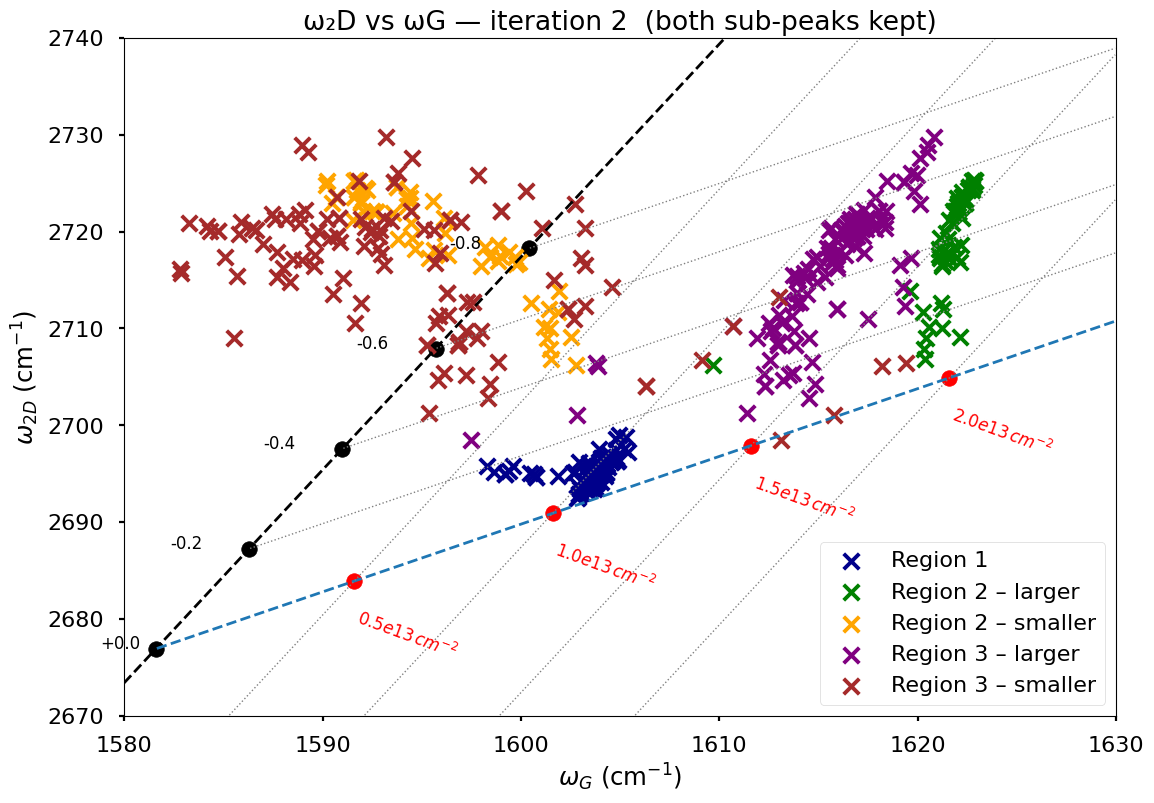

In [11]:
# ---------------------------------------------------------------------
# ωG-ω2D correlation — iteration 2: **both peaks** from double-Lorentzian fits
#   – For region 2 & 3 we keep **both** the larger-amplitude (“larger”) and
#     the lower-amplitude (“smaller”) sub-peaks of the G-band doublet.
#   – Every kept peak gets its own entry in wg_peaks / w2d_peaks and a unique
#     colour-code tag:
#         0  = Region 1  (single peak)
#         1  = Region 2, larger sub-peak
#         2  = Region 2, smaller sub-peak
#         3  = Region 3, larger sub-peak
#         4  = Region 3, smaller sub-peak
# ---------------------------------------------------------------------

# ─────────────────────────────────────────────────────────────
# 1)  G-band centre frequencies  (ωG)
# ─────────────────────────────────────────────────────────────
# Region 1  ─ single Lorentzian
g_g_params  = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], [300, 1600, 10, 10],
    "g-points.txt"
)
wg_peaks    = g_g_params[:, 1]                    # (N1,)
color_code  = np.zeros_like(wg_peaks)            # tag 0

# Region 2  ─ double Lorentzian  →  keep *both* sub-peaks
initial_guesses2 = [300, 1600, 5, 50, 1620, 5, 10]
moo3_g_g_params  = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-g.txt"
)
# larger (higher A)   → tag 1
wg_peaks  = np.concatenate((
    wg_peaks,
    np.where(moo3_g_g_params[:, 0] > moo3_g_g_params[:, 3],
             moo3_g_g_params[:, 1],
             moo3_g_g_params[:, 4])
))
color_code = np.concatenate((color_code, np.ones(len(moo3_g_g_params))))
# smaller sub-peak    → tag 2
wg_peaks  = np.concatenate((
    wg_peaks,
    np.where(moo3_g_g_params[:, 0] < moo3_g_g_params[:, 3],
             moo3_g_g_params[:, 1],
             moo3_g_g_params[:, 4])
))
color_code = np.concatenate((color_code, 2*np.ones(len(moo3_g_g_params))))

# Region 3  ─ double Lorentzian (same logic)
moo3_thick_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2, "moo3-thick.txt"
)
# larger sub-peak     → tag 3
wg_peaks  = np.concatenate((
    wg_peaks,
    np.where(moo3_thick_g_params[:, 0] > moo3_thick_g_params[:, 3],
             moo3_thick_g_params[:, 1],
             moo3_thick_g_params[:, 4])
))
color_code = np.concatenate((color_code, 3*np.ones(len(moo3_thick_g_params))))
# smaller sub-peak    → tag 4
wg_peaks  = np.concatenate((
    wg_peaks,
    np.where(moo3_thick_g_params[:, 0] < moo3_thick_g_params[:, 3],
             moo3_thick_g_params[:, 1],
             moo3_thick_g_params[:, 4])
))
color_code = np.concatenate((color_code, 4*np.ones(len(moo3_thick_g_params))))

# ─────────────────────────────────────────────────────────────
# 2)  2D-band centre frequencies  (ω2D) – single Lorentzian
#     (duplicate each entry for the two sub-peaks so array lengths match)
# ─────────────────────────────────────────────────────────────
initial_guesses_2d = [100, 2700, 10, 10]
neighbourhood_2d   = [2600, 2790]

g_2d_params          = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "g-points.txt")
w2d_peaks            = g_2d_params[:, 1]                       # Region 1 (N1,)

moo3_g_2d_params     = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-g.txt")
# duplicate → same ω2D for both sub-peaks
w2d_peaks            = np.concatenate((
    w2d_peaks,
    moo3_g_2d_params[:, 1],
    moo3_g_2d_params[:, 1]
))

moo3_thick_2d_params = fn.get_peak_params(fn.lorentzian, raman_amplitudes,
                                          coordinates, wave_numbers,
                                          neighbourhood_2d, initial_guesses_2d,
                                          "moo3-thick.txt")
w2d_peaks            = np.concatenate((
    w2d_peaks,
    moo3_thick_2d_params[:, 1],
    moo3_thick_2d_params[:, 1]
))

# ─────────────────────────────────────────────────────────────
# 3)  Collect (x, y) positions – duplicated to match sub-peak count
# ─────────────────────────────────────────────────────────────
point_list  = []
point_list += list(np.loadtxt("g-points.txt",        delimiter=","))
point_list += list(np.loadtxt("moo3-g.txt",          delimiter=","))
point_list += list(np.loadtxt("moo3-g.txt",          delimiter=","))
point_list += list(np.loadtxt("moo3-thick.txt",      delimiter=","))
point_list += list(np.loadtxt("moo3-thick.txt",      delimiter=","))

# ─────────────────────────────────────────────────────────────
# 4)  Remove NaNs & simple outliers
# ─────────────────────────────────────────────────────────────
mask        = ~np.logical_or(np.isnan(wg_peaks), np.isnan(w2d_peaks))
wg_peaks    = wg_peaks[mask]
w2d_peaks   = w2d_peaks[mask]
point_list  = np.asarray(point_list)[mask]
color_code  = color_code[mask]

mask        = wg_peaks >= 1500                 # crude outlier cut
wg_peaks, w2d_peaks = wg_peaks[mask], w2d_peaks[mask]
point_list, color_code = point_list[mask], color_code[mask]

# ─────────────────────────────────────────────────────────────
# 5)  Plot ω2D vs ωG with reference grids
# ─────────────────────────────────────────────────────────────
%matplotlib inline
plt.style.use("seaborn-v0_8-poster")

omega_g_0, omega_2d_0 = 1581.6, 2676.9      # intrinsic positions
strain_slope, hole_slope = 2.2, 0.7
G_strain = -23.5                             # dωG/dε  (cm⁻¹ / %)

wG  = np.arange(1580, 1630, 0.05)
line = lambda w, wG0, w2D0, s: s*w + (w2D0 - s*wG0)

fig, ax = plt.subplots()

# strain & doping baselines
ax.plot(wG, line(wG, omega_g_0, omega_2d_0, strain_slope), "--k", lw=2)
ax.plot(wG[wG > omega_g_0],
        line(wG[wG > omega_g_0], omega_g_0, omega_2d_0, hole_slope),
        "--", c="C0", lw=2)

# strain grid points & dotted extensions
for st in [-0.6, -0.8, -0.4, -0.2, 0]:
    st_G  = omega_g_0 + G_strain*st
    st_2D = line(st_G, omega_g_0, omega_2d_0, strain_slope)
    ax.scatter(st_G, st_2D, c="k")
    ax.text(st_G - (4 if st < 0 else 2.8), st_2D, f"{st:+.1f}", fontsize=12)
    if st:
        wGnew = wG[wG > st_G]
        ax.plot(wGnew,
                hole_slope*wGnew + (st_2D - hole_slope*st_G),
                ":", c="gray", lw=1)

# p-doping grid
for n in [0.5e13, 1e13, 1.5e13, 2e13]:
    dG  = 2*n/1e12
    d2D = dG*hole_slope
    ax.scatter(omega_g_0 + dG, omega_2d_0 + d2D, c="red")
    ax.plot(wG,
            omega_2d_0 + d2D + strain_slope*(wG - omega_g_0 - dG),
            ":", c="gray", lw=1)
    ax.text(omega_g_0 + dG,
            omega_2d_0 + d2D - 8,
            f"{n*1e-13:.1f}$e13\\,cm^{{-2}}$",
            c="red", rotation=-20, fontsize=12)

# data points (five colour classes)
colors = ["darkblue", "green", "orange", "purple", "brown"]
labels = ["Region 1",
          "Region 2 – larger", "Region 2 – smaller",
          "Region 3 – larger", "Region 3 – smaller"]
for code, c, lab in zip(range(5), colors, labels):
    ax.scatter(wg_peaks[color_code == code],
               w2d_peaks[color_code == code],
               c=c, marker="x", label=lab)

ax.set_xlim(1580, 1630)
ax.set_ylim(2670, 2740)
ax.set_xlabel("$\\omega_G$ (cm$^{-1}$)")
ax.set_ylabel("$\\omega_{2D}$ (cm$^{-1}$)")
ax.set_title("ω₂D vs ωG — iteration 2  (both sub-peaks kept)")
ax.legend()
plt.show()


In [12]:
# -----------------------------------------------------------------
# Check how often the **larger-amplitude Lorentzian** in the G-band
# sits on the *higher* wavenumber side (i.e. is the “right” peak).
#
# A double-Lorentzian fit returns:
#   A1,  x01, γ1,   A2, x02, γ2,   B
#        ^^^             ^^^
#   arr[0] arr[1]     arr[3] arr[4]
#
# Logic:
#   • Accept fits where none of the needed parameters are None.
#   • Compare amplitudes (A1 vs A2) **and** centre positions (x01 vs x02):
#       (A1 > A2) != (x01 > x02)
#     If True, the larger‐amplitude peak is also the higher‐frequency one.
# -----------------------------------------------------------------

check_arr = []      # boolean flags, one per spectrum

# ── Region 2 ─────────────────────────────────────────────────────
initial_guesses2 = [300, 1600, 5,     # A1, x01, γ1
                    50,  1620, 5,     # A2, x02, γ2
                    10]               # B

moo3_g_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2,
    "moo3-g.txt"
)

check_arr = np.concatenate((
    check_arr,
    np.array([
        # ensure all four peak parameters exist, then apply the test
        (arr[0] is not None and arr[1] is not None and
         arr[3] is not None and arr[4] is not None) and
        ((arr[0] > arr[3]) != (arr[1] > arr[4]))  # larger amp on right?
        for arr in moo3_g_g_params
    ])
))

# ── Region 3 ─────────────────────────────────────────────────────
moo3_thick_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes, coordinates, wave_numbers,
    [1550, 1700], initial_guesses2,
    "moo3-thick.txt"
)

check_arr = np.concatenate((
    check_arr,
    np.array([
        (arr[0] is not None and arr[1] is not None and
         arr[3] is not None and arr[4] is not None) and
        ((arr[0] > arr[3]) != (arr[1] > arr[4]))
        for arr in moo3_thick_g_params
    ])
))

# ── Summary ─────────────────────────────────────────────────────
percent = np.sum(check_arr) / len(check_arr) * 100
print(f"Percentage of points where the larger G-peak is on the RIGHT: {percent:.2f}%")


Percentage of points where the larger G-peak is on the RIGHT: 4.64%


Observations:

- It is clear that the larger peak follows a specific trend in the omega_g omega_2d plot. The smaller peak  does not follow any trend. 
- In more than 90% of the points, left peak is the larger one


In [48]:
# =============================================================================
# Spatial Scatter of Raman G and 2D Peak Frequencies
# -----------------------------------------------------------------------------
# This script:
#  1. Extracts G-peak frequencies (wg_peaks) from three datasets using
#     single- and double-Lorentzian fits.
#  2. Extracts 2D-peak frequencies (w2d_peaks) similarly.
#  3. Builds a list of measurement coordinates (point_list).
#  4. Filters out invalid (NaN) or outlier points.
#  5. Prepares arrays for plotting where marker shape encodes dataset region
#     and marker color encodes frequency.
# =============================================================================

import numpy as np
import function_lib as fn

# -----------------------------------------------------------------------------
# 1. Extract G‑peak (wg_peaks) from three measurement files
# -----------------------------------------------------------------------------

# File 1: fits a single Lorentzian to 'g-points.txt'
# -----------------------------------------------
#   • Returns array of parameters: [A, x0, gamma, ...]
#   • We take the center frequency x0 at index 1

g_g_params = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    [1550, 1700],       # search window for the G peak
    [300, 1600, 10, 10], # initial [A, x0, gamma, background]
    'g-points.txt'
)
wg_peaks = g_g_params[:, 1]

# color_code: 0 for File 1, 1 for File 2, 2 for File 3
color_code = np.zeros_like(wg_peaks)
# check_arr: Boolean mask of valid fits (initialized to False)
check_arr = np.zeros_like(wg_peaks, dtype=bool)

# File 2: fits a double Lorentzian to 'moo3-g.txt'
# -------------------------------------------------
initial_guesses2 = [
    300, 1600, 5,  # A1, x01 (peak1), γ1
     50, 1620, 5,  # A2, x02 (peak2), γ2
     10           # background level
]
moo3_g_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    [1550, 1700],      # G-peak search window
    initial_guesses2,
    'moo3-g.txt'
)
# Select the dominant Lorentzian center (x01 if A1>A2 else x02)
peak2 = np.array([
    params[1] if params[0] > params[3] else params[4]
    for params in moo3_g_g_params
])
wg_peaks = np.concatenate((wg_peaks, peak2))
color_code = np.concatenate((color_code, np.ones_like(peak2)))
# Mark only those fits where both peaks were non-null and correctly separated
check2 = np.array([
    all(p is not None for p in (p0, p1, p3, p4)) and ((p0 > p3) != (p1 > p3))
    for p0, p1, _, p3, p4, *_ in moo3_g_g_params
])
check_arr = np.concatenate((check_arr, check2))

# File 3: same double‑Lorentzian on 'moo3-thick.txt'
# ---------------------------------------------------
moo3_thick_g_params = fn.get_peak_params(
    fn.double_lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    [1550, 1700],      # G‑peak range
    initial_guesses2,
    'moo3-thick.txt'
)
peak3 = np.array([
    params[1] if params[0] > params[3] else params[4]
    for params in moo3_thick_g_params
])
wg_peaks = np.concatenate((wg_peaks, peak3))
color_code = np.concatenate((color_code, 2 * np.ones_like(peak3)))
check3 = np.array([
    all(p is not None for p in (p0, p1, p3, p4)) and ((p0 > p3) != (p1 > p3))
    for p0, p1, _, p3, p4, *_ in moo3_thick_g_params
])
check_arr = np.concatenate((check_arr, check3))

# -----------------------------------------------------------------------------
# 2. Extract 2D‑peak frequencies (w2d_peaks) similarly from each file
# -----------------------------------------------------------------------------
neighbourhood_2d    = [2600, 2790]
initial_guesses_2d  = [100, 2700, 10, 10]  # [A, x0, γ, background]

# File 1: 'g-points.txt'
g_2d_params = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    neighbourhood_2d,
    initial_guesses_2d,
    'g-points.txt'
)
w2d_peaks = g_2d_params[:, 1]

# File 2: 'moo3-g.txt'
moo3_g_2d_params = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    neighbourhood_2d,
    initial_guesses_2d,
    'moo3-g.txt'
)
w2d_peaks = np.concatenate((w2d_peaks, moo3_g_2d_params[:, 1]))

# File 3: 'moo3-thick.txt'
moo3_thick_2d_params = fn.get_peak_params(
    fn.lorentzian,
    raman_amplitudes,
    coordinates,
    wave_numbers,
    neighbourhood_2d,
    initial_guesses_2d,
    'moo3-thick.txt'
)
w2d_peaks = np.concatenate((w2d_peaks, moo3_thick_2d_params[:, 1]))

# -----------------------------------------------------------------------------
# 3. Load and combine spatial coordinates
# -----------------------------------------------------------------------------
point_list = []
for fname in ('g-points.txt', 'moo3-g.txt', 'moo3-thick.txt'):
    coords = np.loadtxt(fname, delimiter=',')  # each row: [x, y]
    point_list.extend(coords)
point_list = np.array(point_list)

# -----------------------------------------------------------------------------
# 4. Remove invalid fits (NaN in any peak)
# -----------------------------------------------------------------------------
mask = ~np.isnan(wg_peaks) & ~np.isnan(w2d_peaks)
wg_peaks   = wg_peaks[mask]
w2d_peaks  = w2d_peaks[mask]
point_list = point_list[mask]
color_code = color_code[mask]

# -----------------------------------------------------------------------------
# 5. Remove outliers: only keep G‑peaks ≥ threshold
# -----------------------------------------------------------------------------
threshold = 1500  # cm⁻¹
mask = wg_peaks >= threshold
wg_peaks   = wg_peaks[mask]
w2d_peaks  = w2d_peaks[mask]
point_list = point_list[mask]
color_code = color_code[mask]

# At this point:
#  • wg_peaks   : 1D array of G‑peak frequencies (cm⁻¹)
#  • w2d_peaks  : 1D array of 2D‑peak frequencies (cm⁻¹)
#  • point_list : (N,2) array of [x, y] positions (µm)
#  • color_code : integer labels (0,1,2) indicating dataset/region

# Next step: scatter‑plot point_list with marker shapes from color_code and
# color map from wg_peaks (or w2d_peaks), as desired.


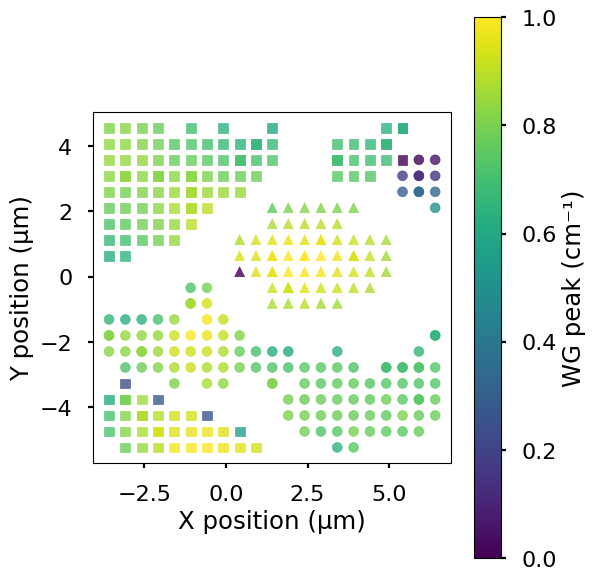

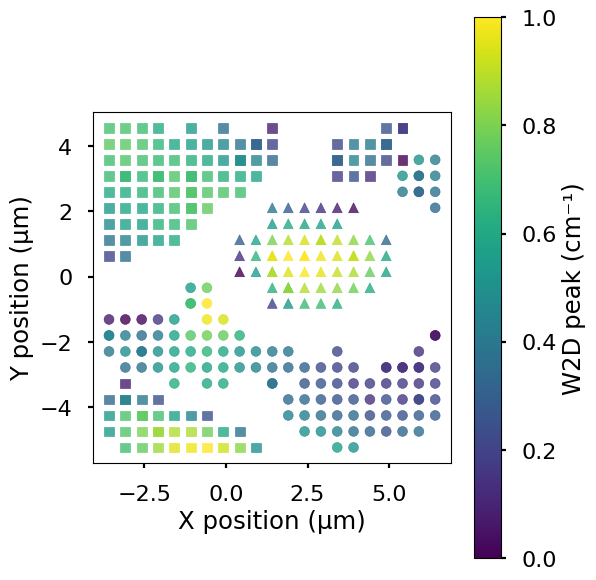

In [49]:

from matplotlib.cm import ScalarMappable

# example inputs
# wg_peaks = np.array([...])
# point_list = np.array([[x1, y1], [x2, y2], …])
# color_code = np.array([0, 1, 2, …])

# define a marker for each region code
marker_map = {
    0: 'o',   # circle
    1: '^',   # triangle_up
    2: 's',   # square
    # add more if you have more region codes
}

cmap = 'viridis'    # or any other colormap you like
size = 50           # marker size
alpha = 0.8         # transparency

fig, ax = plt.subplots(figsize=(6,6))

# plot each region separately so shapes differ
for code in np.unique(color_code):
    idx = color_code == code
    sc = ax.scatter(
        point_list[idx, 0], point_list[idx, 1],
        c=wg_peaks[idx],
        cmap=cmap,
        marker=marker_map.get(code, 'o'),
        s=size,
        alpha=alpha,
        label=f'Region {code}'
    )

# add a single colorbar for all points
cbar = fig.colorbar(ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label('WG peak (cm⁻¹)')

ax.set_xlabel('X position (µm)')
ax.set_ylabel('Y position (µm)')
# ax.legend(title='Region code')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()





fig, ax = plt.subplots(figsize=(6,6))

# plot each region separately so shapes differ
for code in np.unique(color_code):
    idx = color_code == code
    sc = ax.scatter(
        point_list[idx, 0], point_list[idx, 1],
        c=w2d_peaks[idx],
        cmap=cmap,
        marker=marker_map.get(code, 'o'),
        s=size,
        alpha=alpha,
        label=f'Region {code}'
    )

# add a single colorbar for all points
cbar = fig.colorbar(ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label('W2D peak (cm⁻¹)')

ax.set_xlabel('X position (µm)')
ax.set_ylabel('Y position (µm)')
# ax.legend(title='Region code')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()


Tasks - Check if im plotting the right or left peak
